In [32]:
import pyfeats
import cv2
from numpy.random import default_rng
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
def extract_all_pyfeats(img_path):
    # Load image as grayscale
    f = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if f is None:
        raise ValueError("Image not found or failed to load")

    # Create binary mask
    mask = np.ones_like(f, dtype=bool)

    # Extract all supported features
    fos_feats, _ = pyfeats.fos(f, mask)
    glcm_feats, _, _, _  = pyfeats.glcm_features(f)
    glds_feats, _ = pyfeats.glds_features(f, mask)
    ngtdm_feats, _ = pyfeats.ngtdm_features(f, mask)
    sfm_feats, _ = pyfeats.sfm_features(f, mask)
    fdta_feats, _ = pyfeats.fdta(f, mask)
    glrlm_feats, _ = pyfeats.glrlm_features(f, mask)
    fps_feats, _ = pyfeats.fps(f, mask)
    glszm_feats, _ = pyfeats.glszm_features(f, mask)
    lbp_feats, _ = pyfeats.lbp_features(f, mask)
    amfm_feats, _ = pyfeats.amfm_features(f)
   # dwt_feats, _ = pyfeats.dwt_features(f, mask)
    swt_feats, _ = pyfeats.swt_features(f, mask)
    wp_feats, _ = pyfeats.wp_features(f, mask)
    gt_feats, _ = pyfeats.gt_features(f, mask)
    hu_feats, _ = pyfeats.hu_moments(f)
    tas_feats, _ = pyfeats.tas_features(f)
    hog_feats, _ = pyfeats.hog_features(f)
    hist_feats, _ = pyfeats.histogram(f, mask)
    mrh_feats, _  = pyfeats.multiregion_histogram(f, mask)
    lte_feats, _ = pyfeats.lte_measures(f, mask)
    zern_feats, _ = pyfeats.zernikes_moments(f, mask)

    # Reduce GLCM to summary
    glcm_mean = np.mean(glcm_feats)
    glcm_range = np.ptp(glcm_feats)

    # Combine into one vector
    features = np.concatenate([
        fos_feats,
        [glcm_mean, glcm_range],
        glds_feats,
        ngtdm_feats,
        sfm_feats,
        lte_feats,
        fdta_feats,
        glrlm_feats,
        fps_feats,
        glszm_feats,
        lbp_feats,
        hist_feats,
        mrh_feats,
        amfm_feats,
       # dwt_feats,
        swt_feats,
        wp_feats,
        gt_feats,
        zern_feats,
        hu_feats,
        tas_feats,
        hog_feats
    ])

    # Clean NaN or Inf if exist
    return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

In [4]:
paths = []
fake_test = r"C:\Users\Admin\PycharmProjects\SchoolStuff\MachineLerning\Final_Project\test\FAKE"
paths.append(fake_test)
fake_train = r"C:\Users\Admin\PycharmProjects\SchoolStuff\MachineLerning\Final_Project\train\FAKE"
paths.append(fake_train)
real_test = r"C:\Users\Admin\PycharmProjects\SchoolStuff\MachineLerning\Final_Project\test\REAL"
paths.append(real_test)
real_train = r"C:\Users\Admin\PycharmProjects\SchoolStuff\MachineLerning\Final_Project\train\REAL"
paths.append(real_train)

In [6]:
# import os
#
# image_extensions = ('.jpg', '.jpeg', '.png')
# x_train = []
#
# for filename in os.listdir(real_test):
#     if filename.lower().endswith(image_extensions):
#         image_path = os.path.join(real_test, filename)
#         try:
#             features = extract_all_pyfeats(image_path)
#             x_train.append(features)
#         except Exception as e:
#             print(f"Error processing {filename}: {e}")
#
# # Convert list to numpy array
# x_train = np.array(x_train)
#
# # Save to file
# np.save("x_real_test.npy", x_train)


## Node class

In [15]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

## Decision Tree

In [39]:
class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 20, features = None, moi = "gini"):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.features = features
        self.root = None
        self.MOI = moi.lower() if moi.lower() in ("gini", "entropy") else "gini" # metric of impurity

    def fit(self, X, y):
        # X.shape[1] number of features
        self.features = X.shape[1] if self.features is None else min(self.features, X.shape[1])
        self.root = self.build_tree(X, y)

    def build_tree(self, X, y, depth=0):
        x_samples, x_features = X.shape
        y_labels = len(np.unique(y))

        if depth >= self.max_depth or y_labels == 1 or x_samples < self.min_samples_split:
            return Node(value=np.bincount(y).argmax())

        feature_indexes = np.random.choice(x_features, self.features, replace=False)

        best_threshold, best_feature = self.best_split(X, y, feature_indexes)
        if best_threshold is None or best_feature is None:
            return Node(value=np.bincount(y).argmax())

        left_indexes, right_indexes = self.split(X[:, best_feature], best_threshold)

        left_subtree = self.build_tree(X[left_indexes], y[left_indexes], depth=depth+1)
        right_subtree = self.build_tree(X[right_indexes], y[right_indexes], depth=depth+1)
        return Node(best_feature, best_threshold, left_subtree, right_subtree)

    def best_split(self, X, y, feature_indexes):
        best_gain = -1
        best_threshold, best_feature = None, None
        gini_parent = self.gini(y)
        entropy_parent = self.entropy(y)
        n = len(y)
        e = 1e-10

        for feature_index in feature_indexes:
            X_column = X[:, feature_index]
            indexes = np.argsort(X_column)
            X_sorted = X_column[indexes]
            y_sorted = y[indexes]
            thresholds = np.unique(X_sorted)

            split_indices = np.searchsorted(X_sorted, thresholds, side='right')

            for i, threshold in enumerate(thresholds):

                if split_indices[i] == 0 or split_indices[i] == n:
                    continue

                left_label= y_sorted[:split_indices[i]]
                right_label = y_sorted[split_indices[i]:]

                if len(left_label) == 0 or len(right_label) == 0:
                    gain = 0

                elif self.MOI.lower() == "entropy":
                    entropy_left = self.entropy(left_label)
                    entropy_right = self.entropy(right_label)
                    weighted_entropy = (len(left_label) * entropy_left + len(right_label) * entropy_right) / n
                    gain = entropy_parent - weighted_entropy
                    if abs(gain - entropy_parent) < e:
                        break

                else:
                    gini_left = self.gini(left_label)
                    gini_right = self.gini(right_label)
                    weighted_gini = (len(left_label) * gini_left + len(right_label) * gini_right) / n
                    gain = gini_parent - weighted_gini
                    if abs(gain - gini_parent) < e:
                        break

                if gain > best_gain:
                    best_gain = gain
                    best_threshold = threshold
                    best_feature = feature_index

        return best_threshold, best_feature

    def split(self, X_column, threshold):
        left_indexes = np.where(X_column <= threshold)[0].flatten()
        right_indexes = np.where(X_column > threshold)[0].flatten()
        return left_indexes, right_indexes

    def create_probabilitys(self, y):
        counts = np.bincount(y)
        return counts / counts.sum()

    def gini(self, y):
        return 1 - np.sum(self.create_probabilitys(y) ** 2)

    def entropy(self, y):
        p = self.create_probabilitys(y)
        p = p[p > 0]
        return -np.sum(p * np.log(p))

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, X, node):
        """
            if node.is_leaf_node():
                return node.value

            if X[node.feature] <= node.threshold:
                return self.traverse_tree(X, node.left)
            else:
                return self.traverse_tree(X, node.right)
        """
        return node.value if node.is_leaf_node() else self.traverse_tree(X, node.left) if X[node.feature] <= node.threshold else self.traverse_tree(X, node.right)

    def __str__(self):
        return f"Decision Tree({self.MOI})"

## Random Forest

In [40]:
class RandomForest:
    def __init__(self,n_trees = 25 ,min_samples_split = 2, max_depth = 20, features = None, moi = "gini", seed = None, task="classification"):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.features = features
        self.trees = []
        self.MOI = moi.lower() if moi.lower() in ("gini", "entropy") else "gini"
        self.rng = default_rng(seed) # none give random split every time/ seed=None means non-deterministic sampling
        self.task = task

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.features is None:
            if self.task == "classification":
                self.features = int(np.sqrt(n_features))
            else:
                self.features = max(1, n_features // 3)

        for _ in range(self.n_trees):
            sample_indexes = self.rng.integers(0, n_samples, size=n_samples)
            x_sub, y_sub = X[sample_indexes], y[sample_indexes]

            decision_tree = DecisionTree(self.min_samples_split, self.max_depth, self.features, self.MOI)
            decision_tree.fit(x_sub, y_sub)
            self.trees.append(decision_tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        pred_matrix = predictions.T
        n_samples, n_trees = pred_matrix.shape

        # Ensures proper sizing for the bincount
        K = int(pred_matrix.max()) + 1

        # Transforms each class vote into a unique bin index in a flattened 1D histogram of length n_samples * K
        offsets = (np.arange(n_samples) * K)[:, None]
        indexes = (pred_matrix + offsets).ravel()

        # each row in counts represents vote counts per class for a single sample
        counts = np.bincount(indexes, minlength=n_samples * K)
        counts = counts.reshape(n_samples, K)
        # Selects the majority-voted class for each sample
        return counts.argmax(axis=1)

    def __str__(self):
        return f"Random Forest({self.MOI})"


## AdaBoost

In [22]:
class AdaBoost:
    def __init__(self, min_samples_split = 2, estimators = 50, learning_rate = 1, features = None, moi = "gini"):
        self.min_samples_split = min_samples_split
        self.estimators = estimators
        self.learning_rate = learning_rate
        self.features = features
        self.alphas = []
        self.models = []
        self.MOI = moi.lower() if moi.lower() in ("gini", "entropy") else "gini"

    def fit(self, X, y):
        n_samples = len(X)
        sample_weights = np.full(n_samples, 1 / n_samples)

        for _ in range(self.estimators):
            sample_indexes = np.random.choice(n_samples, n_samples, replace=True, p=sample_weights)
            X_sub = X[sample_indexes]
            y_sub = y[sample_indexes]

            decision_tree = DecisionTree(self.min_samples_split, 1, self.features, self.MOI)
            decision_tree.fit(X_sub, y_sub)
            predictions = decision_tree.predict(X)
            predictions = np.where(predictions == 0, -1, 1)

            y_bin = np.where(y == 0, -1, 1)
            error = self.weighted_error(y_bin, predictions, sample_weights)
            alpha = 0.5 * np.log((1 - error) / error)
            sample_weights *= np.exp(- alpha * y_bin * predictions)
            sample_weights /= np.sum(sample_weights)

            self.models.append(decision_tree)
            self.alphas.append(alpha)

    def predict(self, X):
        weighted_sum = np.zeros(len(X))
        for model, alpha in zip(self.models, self.alphas):
            pred = np.where(model.predict(X) == 0, -1, 1)
            weighted_sum += alpha * pred
        return np.where(weighted_sum >= 0, 1, 0)

    def weighted_error(self, y_true, y_pred, sample_weights):
        return np.sum(sample_weights[y_true != y_pred])

    def __str__(self):
        return f"Adaboost({self.MOI})"

## load the database and separate it to training and testing

In [13]:
X_fake_train_path = "x_fake_train.npy"
X_real_train_path = "x_real_train.npy"
X_fake_test_path = "x_fake_test.npy"
X_real_test_path = "x_real_test.npy"
X_train = np.concatenate((np.load(X_fake_train_path), np.load(X_real_train_path)), axis=0)
X_test = np.concatenate((np.load(X_fake_test_path), np.load(X_real_test_path)), axis=0)
y_train = np.array([0] * 50000 + [1] * 50000)
y_test = np.array([0] * 10000 + [1] * 10000)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=98)

## A 2D visualisation of the data on all the trees

In [47]:
 # PCA to reduce to 2D
pca = PCA(n_components=2, random_state=0)
x_train_pca = pca.fit_transform(X_train) # important to know why here there is fit and below there is not
x_test_pca = pca.transform(X_test)

trees = []

d_tree_gini = DecisionTree() # 4:37 min
d_tree_gini.fit(x_train_pca, y_train)
trees.append(d_tree_gini)

d_tree_entropy = DecisionTree(moi="entropy") # 5:17m
d_tree_entropy.fit(x_train_pca, y_train)
trees.append(d_tree_entropy)

r_tree_gini = RandomForest() # 36:36 min
r_tree_gini.fit(x_train_pca, y_train)
trees.append(r_tree_gini)

r_tree_entropy = RandomForest(moi="entropy") # 40 min
r_tree_entropy.fit(x_train_pca, y_train)
trees.append(r_tree_entropy)

a_tree_gini = AdaBoost() # 24:45m
a_tree_gini.fit(x_train_pca, y_train)
trees.append(a_tree_gini)

a_tree_entropy = AdaBoost(moi="entropy") # 26:43m
a_tree_entropy.fit(x_train_pca, y_train)
trees.append(a_tree_entropy)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21648\1811643646.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


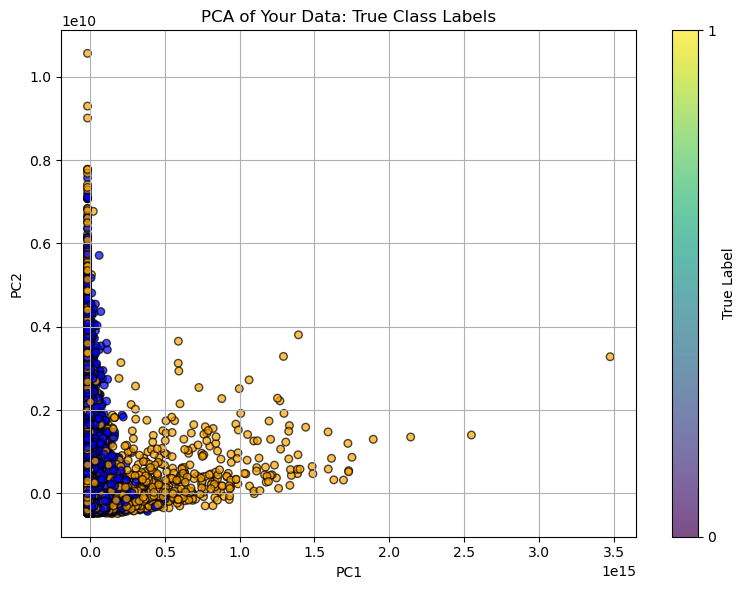

In [45]:
plt.figure(figsize=(8, 6))
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[label] for label in y_train]
plt.scatter(
    x_train_pca[:, 0],        # PC1 on x-axis
    x_train_pca[:, 1],        # PC2 on y-axis
    c=colors,                 # color by true label (0 or 1)
    cmap='viridis',
    s=30,                     # point size
    edgecolor='k',            # black outline for visibility
    alpha=0.7
)
plt.title("PCA of Your Data: True Class Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(ticks=[0,1])
cbar.set_label("True Label")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
preds = []
models = []

d_tree_gini = DecisionTree()
d_tree_gini.fit(X_train, y_train)
models.append(d_tree_gini)
pred_d_tree_gini = d_tree_gini.predict(X_test)
preds.append(pred_d_tree_gini)

d_tree_entropy = DecisionTree(moi="entropy")
d_tree_entropy.fit(X_train, y_train)
models.append(d_tree_entropy)
pred_d_tree_entropy = d_tree_entropy.predict(X_test)
preds.append(pred_d_tree_entropy)

r_tree_gini = RandomForestRegressor()
r_tree_gini.fit(X_train, y_train)
models.append(r_tree_gini)
pred_r_tree_gini = r_tree_gini.predict(X_test)
preds.append(pred_r_tree_gini)

r_tree_entropy = RandomForest(moi="entropy")
r_tree_entropy.fit(X_train, y_train)
models.append(r_tree_entropy)
pred_r_tree_entropy = r_tree_entropy.predict(X_test)
preds.append(pred_r_tree_entropy)

a_tree_gini = AdaBoost()
a_tree_gini.fit(X_train, y_train)
models.append(a_tree_gini)
pred_a_tree_gini = a_tree_gini.predict(X_test)
preds.append(pred_a_tree_gini)

a_tree_entropy = AdaBoost(moi="entropy")
a_tree_entropy.fit(X_train, y_train)
models.append(a_tree_entropy)
pred_a_tree_entropy = a_tree_entropy.predict(X_test)
preds.append(pred_a_tree_entropy)

for i in range(6):
    model = trees[i]
    print(f"{np.sum(y_test == preds[i]) / len(y_test)}, {model[i]}")

In [14]:
# for a later use here is an accuracy calculation
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)